### Pharmaceutical Sales Forecasting
This exercise is part of *Chapter 10* in the book *Applied Machine Learning for Healthcare and Lifesciences on AWS*. Make sure you have completed the steps as outlined in the *Technical requirements* section of *Chapter 10* to successfully complete this exercise.

In this notebook, we will will create two forecasting models using Amazon Forecast. Both forecasting models will be trained to forecast the quantity of a particular drug being sold. The first model will do an hourly forecast and the second model will do a daily forecast.

We will then deploy those models and generate forecasts for hourly and daily time series. Lastly, we will visualize the results in a plot. 

**Note**: Parts of this notebook references the following repository: https://github.com/aws-samples/amazon-forecast-samples/tree/master

Let's start by importing the required libraries for this exercise.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import sagemaker
import json
from tqdm.auto import trange
import time

Next, let's read our data files into a dataframe and examine the records. 

**Note**: The instructions fordownloading and uploading the data files is available in the sub-heading *Acquiring the dataset* in the section  *Building a pharmaceuticalsales forecasting model using Amazon Forecast* of *Chapter 10*. Make sure you have completed those steps before running the notebook further.

In [ ]:
hourly_raw=pd.read_csv('data/saleshourly.csv')
daily_raw=pd.read_csv('data/salesdaily.csv')

In [ ]:
hourly_raw.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014 8:00,0.0,0.67,0.4,2.0,0.0,0.0,0.0,1.0,2014,1,8,Thursday
1,1/2/2014 9:00,0.0,0.00,1.0,0.0,2.0,0.0,0.0,0.0,2014,1,9,Thursday
2,1/2/2014 10:00,0.0,0.00,0.0,3.0,2.0,0.0,0.0,0.0,2014,1,10,Thursday
3,1/2/2014 11:00,0.0,0.00,0.0,2.0,1.0,0.0,0.0,0.0,2014,1,11,Thursday
4,1/2/2014 12:00,0.0,2.00,0.0,5.0,2.0,0.0,0.0,0.0,2014,1,12,Thursday


In [ ]:
daily_raw.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


Next, we will set up some global variables for our notebook that we will be using throughout our exercise. 

In [ ]:
region = boto3.Session("s3").region_name
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')
account_id = boto3.client('sts').get_caller_identity().get('Account')

assert forecast.list_predictors()
sagemaker_session = sagemaker.session.Session()
bucket_name = sagemaker_session.default_bucket()
key='chapter10/data'


To run Amazon Forecast, we need to create an IAM role with previliages to read and write data from S3 and also access APIs of Amazon Forecast. We do this by defining the following functions. 

In [ ]:
def get_or_create_iam_role( role_name ):

    iam = boto3.client("iam")

    assume_role_policy_document = {
        "Version": "2012-10-17",
        "Statement": [
            {
              "Effect": "Allow",
              "Principal": {
                "Service": "forecast.amazonaws.com"
              },
              "Action": "sts:AssumeRole"
            }
        ]
    }

    try:
        create_role_response = iam.create_role(
            RoleName = role_name,
            AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
        )
        role_arn = create_role_response["Role"]["Arn"]
        print("Created", role_arn)
        
        print("Attaching policies...")
        iam.attach_role_policy(
            RoleName = role_name,
            PolicyArn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
        )

        iam.attach_role_policy(
            RoleName=role_name,
            PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
        )

        print("Waiting for a minute to allow IAM role policy attachment to propagate")
        for i in trange(60):
            time.sleep(1.0)
            
    except iam.exceptions.EntityAlreadyExistsException:
        print("The role " + role_name + " already exists, skipping creation")
        role_arn = boto3.resource('iam').Role(role_name).arn

    print("Done.")
    return role_arn

Lets run the above funtion to get our Forecast Role

In [ ]:
role_arn = get_or_create_iam_role( role_name = 'ForecastNotebookRole-Basic' )
role_arn

The role ForecastNotebookRole-Basic already exists, skipping creation
Done.


'arn:aws:iam::485822383573:role/ForecastNotebookRole-Basic'

We will now create a target data frame for our hourly forecast data. We choose the drug M01AB for our forecast generation. The target DF consists of three columns: `datum` which has the timestamp, `M01AB` which has the sale quantities and `item_id` with the value "`M01AB`". 

In [ ]:
hourly_raw['datum'] = pd.to_datetime(hourly_raw["datum"])
target_df=hourly_raw[['datum','M01AB']]
target_df['item_id'] = "M01AB"

target_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,datum,M01AB,item_id
0,2014-01-02 08:00:00,0.0,M01AB
1,2014-01-02 09:00:00,0.0,M01AB
2,2014-01-02 10:00:00,0.0,M01AB
3,2014-01-02 11:00:00,0.0,M01AB
4,2014-01-02 12:00:00,0.0,M01AB


We will now visualize the data for the first 200 rows in our target DF.

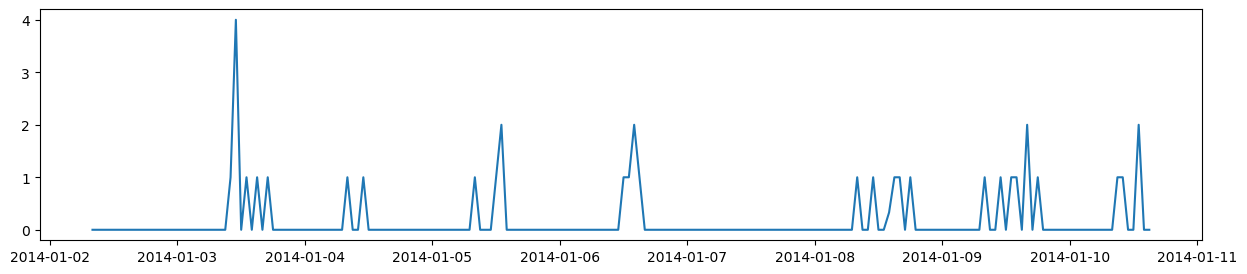

In [ ]:
target_df.to_csv('data/target_df.csv', index=False)
plt.figure(figsize=(15, 3))
plt.plot(target_df['datum'][:200], target_df['M01AB'][:200])
plt.show()

Similar to the hourly forecast, we create a target data frame for our daily forecast and visualize the data for the first 100 rows.

In [ ]:
daily_raw['datum'] = pd.to_datetime(daily_raw["datum"])
target_df_daily=daily_raw[['datum','M01AB']]
target_df_daily['item_id'] = "M01AB"

target_df_daily.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,datum,M01AB,item_id
0,2014-01-02,0.0,M01AB
1,2014-01-03,8.0,M01AB
2,2014-01-04,2.0,M01AB
3,2014-01-05,4.0,M01AB
4,2014-01-06,5.0,M01AB


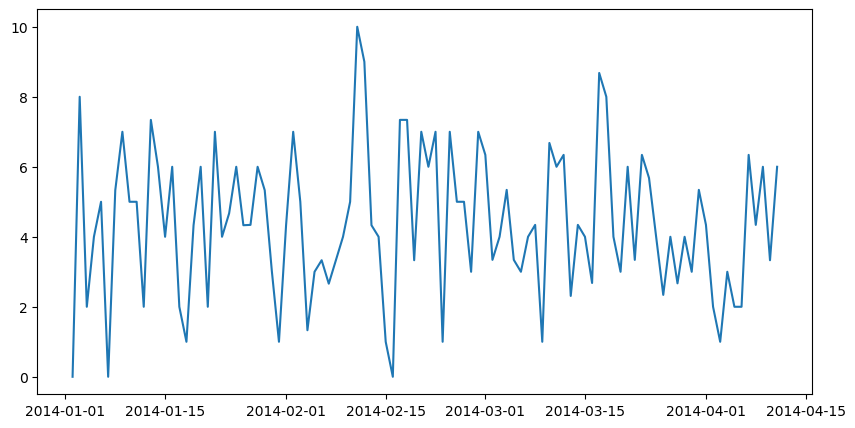

In [ ]:
target_df_daily.to_csv('data/target_df_daily.csv', index=False)
plt.figure(figsize=(10, 5))
plt.plot(target_df_daily['datum'][:100], target_df_daily['M01AB'][:100])
plt.show()

Next, we will upload both these files to S3.

In [ ]:
s3 = boto3.Session().resource('s3')
s3.Bucket(bucket_name).Object(key+'/target_df.csv').upload_file('data/target_df.csv')
ts_s3_path = f"s3://{bucket_name}/{key}/target_df.csv"

print(f"\nDone, the dataset is uploaded to S3 at {ts_s3_path}.")


Done, the dataset is uploaded to S3 at s3://sagemaker-us-east-1-485822383573/chapter10/data/target_df.csv.


In [ ]:
s3.Bucket(bucket_name).Object(key+'/target_df_daily.csv').upload_file('data/target_df_daily.csv')
ts_s3_path_daily = f"s3://{bucket_name}/{key}/target_df_daily.csv"

print(f"\nDone, the dataset is uploaded to S3 at {ts_s3_path_daily}.")


Done, the dataset is uploaded to S3 at s3://sagemaker-us-east-1-485822383573/chapter10/data/target_df_daily.csv.


#### Working with Amazon Forecast

We are now ready to start working through the steps of creating our forecasting model in Amazon Forecast. To begin, let's first create two dataset groups, one for the hourly forecast and the other for our daily forecasts.

In [ ]:
dataset_group_name = "pharma_sales"
dataset_arns = []
try:
    create_dataset_group_response = \
        forecast.create_dataset_group(Domain="CUSTOM",
                                      DatasetGroupName=dataset_group_name,
                                      DatasetArns=dataset_arns)
    dataset_group_arn = create_dataset_group_response['DatasetGroupArn']
    print('Dataset group {} created with ARN: {}'.format(dataset_group_name, dataset_group_arn))
except:
    dataset_group_arn='arn:aws:forecast:{}:{}:dataset-group/{}'.format(region, account_id, dataset_group_name)
    response=forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)
    print('Dataset group {} created with ARN: {}'.format(dataset_group_name, response['DatasetGroupArn']))
    

Dataset group pharma_sales created with ARN: arn:aws:forecast:us-east-1:485822383573:dataset-group/pharma_sales


In [ ]:
dataset_group_name_daily = "pharma_sales_daily"
dataset_arns_daily = []

try:
    create_dataset_group_response = \
        forecast.create_dataset_group(Domain="CUSTOM",
                                      DatasetGroupName=dataset_group_name_daily,
                                      DatasetArns=dataset_arns_daily)
    dataset_group_arn_daily = create_dataset_group_response['dataset_group_name_daily']
    print('Dataset group {} created with ARN: {}'.format(dataset_group_name_daily, dataset_group_name_daily))

except:   
    dataset_group_arn_daily='arn:aws:forecast:{}:{}:dataset-group/{}'.format(region, account_id, dataset_group_name_daily)
    response=forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn_daily)
    print('Dataset group {} created with ARN: {}'.format(dataset_group_name_daily, response['DatasetGroupArn']))
    

Dataset group pharma_sales_daily created with ARN: arn:aws:forecast:us-east-1:485822383573:dataset-group/pharma_sales_daily


Next, we create a dataset schema and a dataset for both the hourly and the daily forecasts. 

In [ ]:
TS_SCHEMA = {
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

In [ ]:
DATASET_FREQUENCY = "H"
TS_DATASET_NAME = dataset_group_name+"_MOIAB"
try:
    create_dataset_response = forecast.create_dataset(Domain="CUSTOM",
                                                      DatasetType='TARGET_TIME_SERIES',
                                                      DatasetName=TS_DATASET_NAME,
                                                      DataFrequency=DATASET_FREQUENCY,
                                                      Schema=TS_SCHEMA)

    ts_dataset_arn = create_dataset_response['DatasetArn']
    print('Dataset {} created with ARN: {}'.format(TS_DATASET_NAME, ts_dataset_arn))
except:
    ts_dataset_arn='arn:aws:forecast:{}:{}:dataset/{}'.format(region, account_id, TS_DATASET_NAME)
    response=describe_dataset_response = forecast.describe_dataset(DatasetArn=ts_dataset_arn)
    print('Dataset {} created with ARN: {}'.format(TS_DATASET_NAME, response['DatasetArn']))

Dataset pharma_sales_MOIAB created with ARN: arn:aws:forecast:us-east-1:485822383573:dataset/pharma_sales_MOIAB


In [ ]:
DATASET_FREQUENCY_D = "D"
TS_DATASET_NAME_DAILY = dataset_group_name+"_MOIAB_DAILY"

try:
    create_dataset_response = forecast.create_dataset(Domain="CUSTOM",
                                                      DatasetType='TARGET_TIME_SERIES',
                                                      DatasetName=TS_DATASET_NAME_DAILY,
                                                      DataFrequency=DATASET_FREQUENCY_D,
                                                      Schema=TS_SCHEMA)

    ts_dataset_arn_daily = create_dataset_response['DatasetArn']
    print('Dataset {} created with ARN: {}'.format(TS_DATASET_NAME_DAILY, ts_dataset_arn_daily))
except:
    ts_dataset_arn_daily='arn:aws:forecast:{}:{}:dataset/{}'.format(region, account_id, TS_DATASET_NAME_DAILY)
    response=describe_dataset_response = forecast.describe_dataset(DatasetArn=ts_dataset_arn_daily)
    print('Dataset {} created with ARN: {}'.format(TS_DATASET_NAME_DAILY, response['DatasetArn']))

Dataset pharma_sales_MOIAB_DAILY created with ARN: arn:aws:forecast:us-east-1:485822383573:dataset/pharma_sales_MOIAB_DAILY


With both datasets created, it is now time to add them to their corresponding dataset groups. 

In [ ]:
dataset_arns=[]
dataset_arns.append(ts_dataset_arn)
print(dataset_arns)
try:
    response=forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)
    print(response)
except:
    response=forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)
    print(response)

['arn:aws:forecast:us-east-1:485822383573:dataset/pharma_sales_MOIAB']
{'ResponseMetadata': {'RequestId': '0ce06467-5140-4960-82a1-2ed86887ea19', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Wed, 31 Aug 2022 22:55:08 GMT', 'x-amzn-requestid': '0ce06467-5140-4960-82a1-2ed86887ea19', 'content-length': '2', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [ ]:
dataset_arns=[]
dataset_arns.append(ts_dataset_arn_daily)
print(dataset_arns)
try:
    response=forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn_daily, DatasetArns=dataset_arns)
    print(response)
except:
    response=forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn_daily)
    print(response)

['arn:aws:forecast:us-east-1:485822383573:dataset/pharma_sales_MOIAB_DAILY']
{'ResponseMetadata': {'RequestId': '14d470fb-5749-4959-ae21-58a32359e067', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Wed, 31 Aug 2022 22:55:09 GMT', 'x-amzn-requestid': '14d470fb-5749-4959-ae21-58a32359e067', 'content-length': '2', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


Everything is now set up to begin importing our datasets into Amazon Forecast. Let's do that for our hourly and daily datasets.

In [ ]:
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"
TS_IMPORT_JOB_NAME = "HOURLY_IMPORT"
TIMEZONE = "EST"

try:

    ts_dataset_import_job_response = \
        forecast.create_dataset_import_job(DatasetImportJobName=TS_IMPORT_JOB_NAME,
                                           DatasetArn=ts_dataset_arn,
                                           DataSource= {
                                             "S3Config" : {
                                                 "Path": ts_s3_path,
                                                 "RoleArn": role_arn
                                             } 
                                           },
                                           TimestampFormat=TIMESTAMP_FORMAT,
                                           TimeZone = TIMEZONE)

    ts_dataset_import_job_arn = ts_dataset_import_job_response['DatasetImportJobArn']
    describe_dataset_import_job_response = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)
    print(f"Waiting for Dataset Import Job with ARN {ts_dataset_import_job_arn} to become ACTIVE. This process could take 5-10 minutes.\n\nCurrent Status:")

    while True:
        status=forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)['Status']
        print(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(10)
except:
    ts_dataset_import_job_arn='arn:aws:forecast:{}:{}:dataset-import-job/{}/{}'.format(region, account_id, TS_DATASET_NAME,TS_IMPORT_JOB_NAME)
    response=forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)
    print(f"\n\nThe Dataset Import Job with ARN {ts_dataset_import_job_arn} is now {response['Status']}.")



The Dataset Import Job with ARN arn:aws:forecast:us-east-1:485822383573:dataset-import-job/pharma_sales_MOIAB/HOURLY_IMPORT is now ACTIVE.


In [ ]:
TIMESTAMP_FORMAT_DAILY = "yyyy-MM-dd"
TS_IMPORT_JOB_NAME_DAILY = "DAILY_IMPORT"
TIMEZONE = "EST"

try:

    ts_dataset_import_job_response = \
        forecast.create_dataset_import_job(DatasetImportJobName=TS_IMPORT_JOB_NAME_DAILY,
                                           DatasetArn=ts_dataset_arn_daily,
                                           DataSource= {
                                             "S3Config" : {
                                                 "Path": ts_s3_path_daily,
                                                 "RoleArn": role_arn
                                             } 
                                           },
                                           TimestampFormat=TIMESTAMP_FORMAT_DAILY,
                                           TimeZone = TIMEZONE)

    ts_dataset_import_job_arn_daily = ts_dataset_import_job_response['DatasetImportJobArn']
    describe_dataset_import_job_response = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn_daily)
    print(f"Waiting for Dataset Import Job with ARN {ts_dataset_import_job_arn_daily} to become ACTIVE. This process could take 5-10 minutes.\n\nCurrent Status:")

    while True:
        status=forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn_daily)['Status']
        print(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(10)
except:
    ts_dataset_import_job_arn_daily='arn:aws:forecast:{}:{}:dataset-import-job/{}/{}'.format(region, account_id, TS_DATASET_NAME_DAILY,TS_IMPORT_JOB_NAME_DAILY)
    response=forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn_daily)
    print(f"\n\nThe Dataset Import Job with ARN {ts_dataset_import_job_arn_daily} is now {response['Status']}.")



The Dataset Import Job with ARN arn:aws:forecast:us-east-1:485822383573:dataset-import-job/pharma_sales_MOIAB_DAILY/DAILY_IMPORT is now ACTIVE.


We are now ready to train our forecasting models. For the hourly forecast, we will use the DeepAR+ forecasting algorithm. To learn more about DeepAR+, look at the following link: https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-recipe-deeparplus.html

In [ ]:
algorithm_arn = 'arn:aws:forecast:::algorithm/'
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deep_ar = f"{TS_DATASET_NAME}_{algorithm.lower()}"
print(f"Predictor Name = {predictor_name_deep_ar}")

Predictor Name = pharma_sales_MOIAB_deep_ar_plus


#### **Note**: The model creation process could take up to an hour. If you lose connection to the notebook, you can monitor the progress in the AWS console by going to Amazon Forecast service and navigating to the predictors under dataset group. You can then come back to the notebook at any time and re-run the cells from the beginning. The notebook is written in such a way that it checks for the availability of resources before creating them. 

In [ ]:
FORECAST_LENGTH = 24

try:
    create_predictor_response = \
        forecast.create_predictor(PredictorName=predictor_name_deep_ar,
                                  AlgorithmArn=algorithm_arn_deep_ar_plus,
                                  ForecastHorizon=FORECAST_LENGTH,
                                  PerformAutoML=False,
                                  PerformHPO=False,
                                  InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                                  FeaturizationConfig= {"ForecastFrequency": 'H'}
                                 )
    predictor_arn_deep_ar = create_predictor_response['PredictorArn']
    print(f"Waiting for predictor with ARN {predictor_arn_deep_ar} to become ACTIVE. This process could take upto an hour.\n\nCurrent Status:")
    while True:
        status=forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)['Status']
        print(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(10)
    print(f"Predictor with ARN {predictor_arn_deep_ar} :{status}")
except:
    predictor_arn_deep_ar='arn:aws:forecast:{}:{}:predictor/{}'.format(region, account_id, predictor_name_deep_ar)
    status=forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)['Status']
    print(f"Predictor with ARN {predictor_arn_deep_ar}: {status}")
    

Predictor with ARN arn:aws:forecast:us-east-1:485822383573:predictor/pharma_sales_MOIAB_deep_ar_plus: ACTIVE


For our daily forecasting algorithm, we choose Prophet. To know more about Prophet, you can refer to the following link: https://facebook.github.io/prophet/

In [ ]:
algorithm_daily = 'Prophet'
algorithm_arn_prophet = algorithm_arn + algorithm_daily
predictor_name_prophet = f"{TS_DATASET_NAME_DAILY}_{algorithm_daily.lower()}"
print(f"Predictor Name = {predictor_name_prophet}")

Predictor Name = pharma_sales_MOIAB_DAILY_prophet


In [ ]:
FORECAST_LENGTH = 10

try:
    create_predictor_response = \
        forecast.create_predictor(PredictorName=predictor_name_prophet,
                                  AlgorithmArn=algorithm_arn_prophet,
                                  ForecastHorizon=FORECAST_LENGTH,
                                  PerformAutoML=False,
                                  PerformHPO=False,
                                  InputDataConfig= {"DatasetGroupArn": dataset_group_arn_daily},
                                  FeaturizationConfig= {"ForecastFrequency": 'D'}
                                 )
    predictor_arn_prophet = create_predictor_response['PredictorArn']
    print(f"Waiting for predictor with ARN {predictor_arn_prophet} to become ACTIVE. This process could take upto an hour.\n\nCurrent Status:")
    while True:
        status=forecast.describe_predictor(PredictorArn=predictor_arn_prophet)['Status']
        print(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(10)
except:
    predictor_arn_prophet='arn:aws:forecast:{}:{}:predictor/{}'.format(region, account_id, predictor_name_prophet)
    status=forecast.describe_predictor(PredictorArn=predictor_arn_prophet)['Status']
    print(f"Predictor with ARN {predictor_arn_prophet}: {status}")
    

Waiting for predictor with ARN arn:aws:forecast:us-east-1:485822383573:predictor/pharma_sales_MOIAB_DAILY_prophet to become ACTIVE. This process could take upto an hour.

Current Status:
CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS


We are now ready with our forecasting models!

Before we generate forecasts from our model, let's evaluate the models by looking at the metrics, such as RMSE and Loss. 

In [ ]:
error_metrics_deep_ar_plus = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deep_ar)
error_metrics_deep_ar_plus

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 0.06799650728058045,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 2.0969126952121213},
       {'Quantile': 0.5, 'LossValue': 1.1322591406060607},
       {'Quantile': 0.1, 'LossValue': 0.47394512951515155}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 1.3516351381818186,
        'RMSE': 0.06799650728058045,
        'MASE': 0.6476585037121213,
        'MAPE': 0.041576848169191924}],
      'AverageWeightedQuantileLoss': 1.2343723217777778}},
    {'TestWindowStart': datetime.datetime(2019, 10, 7, 20, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2019, 10, 8, 20, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 0.06799650728058045,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 2.096912

In [ ]:
error_metrics_deep_prophet = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_prophet)
error_metrics_deep_prophet

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 3.0596799872347615,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.25128823738391604},
       {'Quantile': 0.5, 'LossValue': 0.4971848669717803},
       {'Quantile': 0.1, 'LossValue': 0.2134212338073586}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.4999918446339709,
        'RMSE': 3.0596799872347615,
        'MASE': 0.6692198535870074,
        'MAPE': 2.006533810005778}],
      'AverageWeightedQuantileLoss': 0.3206314460543516}},
    {'TestWindowStart': datetime.datetime(2019, 9, 29, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2019, 10, 9, 0, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 3.0596799872347615,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.25128823738391604},

Next, let's generate forecasts from our hourly model and look at the forecast values. 

In [ ]:
forecast_name_deep_ar = f"{TS_DATASET_NAME}_deeparp"
print(f"Forecast Name = {forecast_name_deep_ar}")

Forecast Name = pharma_sales_MOIAB_deeparp


In [ ]:
try:
    create_forecast_response_deep_ar = forecast.create_forecast(ForecastName=forecast_name_deep_ar,
                                                            PredictorArn=predictor_arn_deep_ar)
    forecast_arn_deep_ar = create_forecast_response_deep_ar['ForecastArn']
    print('creating forecast...')
    while True:
        status=forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar)['Status']
        print(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(10)
    print('Forecast {}: {}'.format(forecast_arn_deep_ar, status))
except:
    forecast_arn_deep_ar='arn:aws:forecast:{}:{}:forecast/{}'.format(region, account_id, forecast_name_deep_ar)
    status=forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar)['Status']
    print('Forecast {}: {}'.format(forecast_arn_deep_ar, status))
    
    

creating forecast...
CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROG

In [ ]:
forecast_response_deep = forecastquery.query_forecast(
    ForecastArn=forecast_arn_deep_ar,
    Filters={"item_id": 'M01AB'})
forecast_response_deep

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2019-10-08T20:00:00',
     'Value': -0.0212139282},
    {'Timestamp': '2019-10-08T21:00:00', 'Value': -0.023361275},
    {'Timestamp': '2019-10-08T22:00:00', 'Value': -0.0044957907},
    {'Timestamp': '2019-10-08T23:00:00', 'Value': -0.0029490117},
    {'Timestamp': '2019-10-09T00:00:00', 'Value': -0.0014466448},
    {'Timestamp': '2019-10-09T01:00:00', 'Value': -0.0008959283},
    {'Timestamp': '2019-10-09T02:00:00', 'Value': -0.0005988376},
    {'Timestamp': '2019-10-09T03:00:00', 'Value': -0.0009790345},
    {'Timestamp': '2019-10-09T04:00:00', 'Value': -0.0011201639},
    {'Timestamp': '2019-10-09T05:00:00', 'Value': -0.0009358527},
    {'Timestamp': '2019-10-09T06:00:00', 'Value': -0.0010048471},
    {'Timestamp': '2019-10-09T07:00:00', 'Value': -0.0019908166},
    {'Timestamp': '2019-10-09T08:00:00', 'Value': -0.0163108818},
    {'Timestamp': '2019-10-09T09:00:00', 'Value': -0.0297796},
    {'Timestamp': '2019-10-09T10:00:00', 

Next, we do the same with our daily forecasting model. 

In [ ]:
forecast_name_prophet = f"{TS_DATASET_NAME_DAILY}_prophetp"
print(f"Forecast Name = {forecast_name_prophet}")

Forecast Name = pharma_sales_MOIAB_DAILY_prophetp


In [ ]:
try:
    create_forecast_response_prophet = forecast.create_forecast(ForecastName=forecast_name_prophet,
                                                            PredictorArn=predictor_arn_prophet)
    forecast_arn_prophet = create_forecast_response_prophet['ForecastArn']
    print('creating forecast...')
    while True:
        status=forecast.describe_forecast(ForecastArn=forecast_arn_prophet)['Status']
        print(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(10)
except:
    forecast_arn_prophet='arn:aws:forecast:{}:{}:forecast/{}'.format(region, account_id, forecast_name_prophet)
    status=forecast.describe_forecast(ForecastArn=forecast_arn_prophet)['Status']
    print('Forecast {}: {}'.format(forecast_arn_prophet, status))

creating forecast...
CREATE_PENDING
CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS

In [ ]:
forecast_response_prophet = forecastquery.query_forecast(
    ForecastArn=forecast_arn_prophet,
    Filters={"item_id": 'M01AB'})
forecast_response_prophet

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2019-10-09T00:00:00',
     'Value': 1.462746530777669},
    {'Timestamp': '2019-10-10T00:00:00', 'Value': 1.6544983804988713},
    {'Timestamp': '2019-10-11T00:00:00', 'Value': 2.3420233215148274},
    {'Timestamp': '2019-10-12T00:00:00', 'Value': 3.1091269782066266},
    {'Timestamp': '2019-10-13T00:00:00', 'Value': 1.633604720688672},
    {'Timestamp': '2019-10-14T00:00:00', 'Value': 2.3361593147671234},
    {'Timestamp': '2019-10-15T00:00:00', 'Value': 1.647074061582626},
    {'Timestamp': '2019-10-16T00:00:00', 'Value': 1.3361628291408434},
    {'Timestamp': '2019-10-17T00:00:00', 'Value': 1.2433693197833207},
    {'Timestamp': '2019-10-18T00:00:00', 'Value': 1.196854202920894}],
   'p50': [{'Timestamp': '2019-10-09T00:00:00', 'Value': 5.490764825297313},
    {'Timestamp': '2019-10-10T00:00:00', 'Value': 4.384191757858938},
    {'Timestamp': '2019-10-11T00:00:00', 'Value': 5.263552781863659},
    {'Timestamp': '2019-10-12T00:00:0

Finally, we visualize the forecast values in a plot.

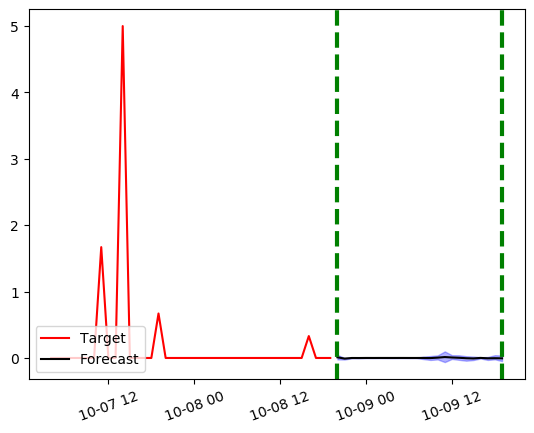

In [ ]:
p10 = pd.DataFrame(forecast_response_deep['Forecast']['Predictions']['p10'])
p50 = pd.DataFrame(forecast_response_deep['Forecast']['Predictions']['p50'])
p90 = pd.DataFrame(forecast_response_deep['Forecast']['Predictions']['p90'])
pred_int = p50['Timestamp'].apply(lambda x: pd.Timestamp(x))
fcst_start_date = pred_int.iloc[0]
fcst_end_date = pred_int.iloc[-1]
time_int = target_df['datum'].apply(lambda x: pd.Timestamp(x))
plt.plot(time_int[-40:],target_df['M01AB'].values[-40:], color = 'r')
plt.plot(pred_int, p50['Value'].values, color = 'k')
plt.fill_between(pred_int, 
                 p10['Value'].values,
                 p90['Value'].values,
                 color='b', alpha=0.3);
plt.axvline(x=pd.Timestamp(fcst_start_date), linewidth=3, color='g', ls='dashed')
plt.axvline(x=pd.Timestamp(fcst_end_date), linewidth=3, color='g', ls='dashed')
plt.xticks(rotation=20)
plt.legend(['Target', 'Forecast'], loc = 'lower left')
plt.show()

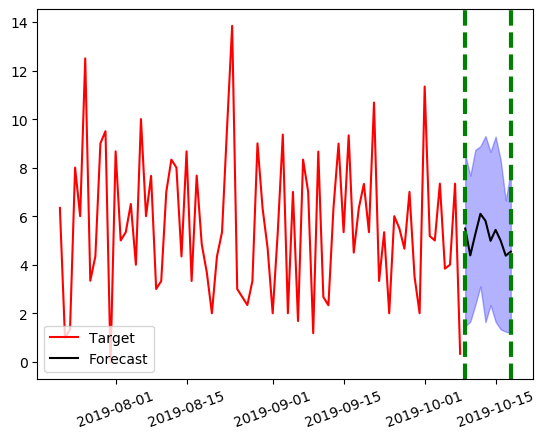

In [ ]:
p10 = pd.DataFrame(forecast_response_prophet['Forecast']['Predictions']['p10'])
p50 = pd.DataFrame(forecast_response_prophet['Forecast']['Predictions']['p50'])
p90 = pd.DataFrame(forecast_response_prophet['Forecast']['Predictions']['p90'])
pred_int = p50['Timestamp'].apply(lambda x: pd.Timestamp(x))
fcst_start_date = pred_int.iloc[0]
fcst_end_date = pred_int.iloc[-1]
time_int = target_df_daily['datum'].apply(lambda x: pd.Timestamp(x))
plt.plot(time_int[-80:],target_df_daily['M01AB'].values[-80:], color = 'r')
plt.plot(pred_int, p50['Value'].values, color = 'k')
plt.fill_between(pred_int, 
                 p10['Value'].values,
                 p90['Value'].values,
                 color='b', alpha=0.3);
plt.axvline(x=pd.Timestamp(fcst_start_date), linewidth=3, color='g', ls='dashed')
plt.axvline(x=pd.Timestamp(fcst_end_date), linewidth=3, color='g', ls='dashed')
plt.xticks(rotation=20)
plt.legend(['Target', 'Forecast'], loc = 'lower left')
plt.show()

You can use this notebook to experiment with other Amazon Forecast algorithm and also generate forecasts for other drugs in the dataset. 
This concludes our exercise. Make sure you stop or delete the Forecast resources to avoid incurring charges. You can find details of how to stop or delete the resources here: https://docs.aws.amazon.com/forecast/latest/dg/manage-resources.html 